In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [186]:
data = pd.read_csv('train.csv')

In [187]:
data.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [188]:
data.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [189]:
float(data.WnvPresent.sum()) / data.count()

Date                      0.052446
Address                   0.052446
Species                   0.052446
Block                     0.052446
Street                    0.052446
Trap                      0.052446
AddressNumberAndStreet    0.052446
Latitude                  0.052446
Longitude                 0.052446
AddressAccuracy           0.052446
NumMosquitos              0.052446
WnvPresent                0.052446
dtype: float64

In [190]:
data.groupby('Species').WnvPresent.sum()

Species
CULEX ERRATICUS             0
CULEX PIPIENS             240
CULEX PIPIENS/RESTUANS    262
CULEX RESTUANS             49
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: WnvPresent, dtype: int64

In [191]:
data.shape

(10506, 12)

In [192]:
# drop redundant columns
data = data[['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent']]

In [193]:
data.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0


In [194]:
# calculate the total number of mos for one trap each day
mos = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).NumMosquitos.sum()

In [195]:
mos.head(20)

Date        Species                 Trap  Latitude   Longitude 
2007-05-29  CULEX PIPIENS           T096  41.731922  -87.677512    1
            CULEX PIPIENS/RESTUANS  T002  41.954690  -87.800991    1
                                    T015  41.974089  -87.824812    1
                                    T048  41.867108  -87.654224    1
                                    T050  41.919343  -87.694259    1
                                    T054  41.921965  -87.632085    2
                                    T086  41.688324  -87.676709    1
                                    T129  41.891126  -87.611560    1
                                    T143  41.999129  -87.795585    1
                                    T148  42.017430  -87.687769    1
            CULEX RESTUANS          T002  41.954690  -87.800991    1
                                    T007  41.994991  -87.769279    1
                                    T015  41.974089  -87.824812    4
                                    T04

In [196]:
wnv = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).WnvPresent.sum()

In [197]:
# put number of mos and virus present back together
df = pd.concat([mos, wnv], axis=1)

In [198]:
# now all the columns we group on are indices, need to convert them back to column names
df.head()

NumMosquitos  \
Date       Species                Trap Latitude  Longitude                  
2007-05-29 CULEX PIPIENS          T096 41.731922 -87.677512             1   
           CULEX PIPIENS/RESTUANS T002 41.954690 -87.800991             1   
                                  T015 41.974089 -87.824812             1   
                                  T048 41.867108 -87.654224             1   
                                  T050 41.919343 -87.694259             1   

                                                             WnvPresent  
Date       Species                Trap Latitude  Longitude               
2007-05-29 CULEX PIPIENS          T096 41.731922 -87.677512           0  
           CULEX PIPIENS/RESTUANS T002 41.954690 -87.800991           0  
                                  T015 41.974089 -87.824812           0  
                                  T048 41.867108 -87.654224           0  
                                  T050 41.919343 -87.694259           0

In [199]:
df.reset_index(level=['Date', 'Species', 'Trap', 'Latitude', 'Longitude'], inplace=True)

In [200]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0


In [201]:
# we have values over 1, need to convert them back to 1
df.WnvPresent.value_counts()

0     8018
1      409
2       31
3        9
4        2
7        1
6        1
5        1
10       1
9        1
8        1
Name: WnvPresent, dtype: int64

In [202]:
df.WnvPresent = df.WnvPresent.apply(lambda x: 1 if x>=1 else 0)

In [203]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0


In [204]:
df.WnvPresent.value_counts()

0    8018
1     457
Name: WnvPresent, dtype: int64

In [205]:
df.shape

(8475, 7)

In [206]:
df.isnull().sum()

Date            0
Species         0
Trap            0
Latitude        0
Longitude       0
NumMosquitos    0
WnvPresent      0
dtype: int64

In [207]:
df.dtypes

Date             object
Species          object
Trap             object
Latitude        float64
Longitude       float64
NumMosquitos      int64
WnvPresent        int64
dtype: object

In [208]:
df.Date = pd.to_datetime(df.Date)

In [209]:
df.dtypes

Date            datetime64[ns]
Species                 object
Trap                    object
Latitude               float64
Longitude              float64
NumMosquitos             int64
WnvPresent               int64
dtype: object

In [210]:
weather = pd.read_csv("weather.csv")

In [211]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [212]:
weather.drop('CodeSum', axis=1, inplace=True)

In [213]:
weather1 = weather[weather['Station']==1]
weather2 = weather[weather['Station']==2]
weather1 = weather1.drop('Station', axis=1)
weather2 = weather2.drop('Station', axis=1)

In [214]:
weather1.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
4,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
6,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,0,M,0.0,T,29.31,30.05,10.4,8,10.8
8,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,0,M,0.0,T,29.40,30.10,11.7,7,12.0


In [215]:
weather1.columns = weather1.columns + str(1)

In [216]:
weather1.columns

Index([u'Date1', u'Tmax1', u'Tmin1', u'Tavg1', u'Depart1', u'DewPoint1',
       u'WetBulb1', u'Heat1', u'Cool1', u'Sunrise1', u'Sunset1', u'Depth1',
       u'Water11', u'SnowFall1', u'PrecipTotal1', u'StnPressure1',
       u'SeaLevel1', u'ResultSpeed1', u'ResultDir1', u'AvgSpeed1'],
      dtype='object')

In [217]:
weather1.rename(columns={'Date1': 'Date'}, inplace=True)

In [218]:
weather2.columns = weather2.columns +str(2)

In [219]:
weather2.rename(columns={'Date2': 'Date'}, inplace=True)

In [220]:
weather = weather1.merge(weather2, on='Date')

In [221]:
weather.head()

,Date,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,WetBulb1,Heat1,Cool1,Sunrise1,...,Sunset2,Depth2,Water12,SnowFall2,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,-,M,M,M,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,-,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,-,M,M,M,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,-,M,M,M,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,-,M,M,M,T,29.46,30.09,11.2,7,11.5


In [222]:
weather.Date = pd.to_datetime(weather.Date)

In [223]:
df = pd.merge(df, weather, on='Date', how='left')

In [224]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax1,Tmin1,Tavg1,...,Sunset2,Depth2,Water12,SnowFall2,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,88,60,74,...,-,M,M,M,0.00,29.44,30.09,5.8,16,7.4
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,88,60,74,...,-,M,M,M,0.00,29.44,30.09,5.8,16,7.4
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,88,60,74,...,-,M,M,M,0.00,29.44,30.09,5.8,16,7.4
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,88,60,74,...,-,M,M,M,0.00,29.44,30.09,5.8,16,7.4
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,88,60,74,...,-,M,M,M,0.00,29.44,30.09,5.8,16,7.4


In [225]:
df.isnull().sum()

Date            0
Species         0
Trap            0
Latitude        0
Longitude       0
NumMosquitos    0
WnvPresent      0
Tmax1           0
Tmin1           0
Tavg1           0
Depart1         0
DewPoint1       0
WetBulb1        0
Heat1           0
Cool1           0
Sunrise1        0
Sunset1         0
Depth1          0
Water11         0
SnowFall1       0
PrecipTotal1    0
StnPressure1    0
SeaLevel1       0
ResultSpeed1    0
ResultDir1      0
AvgSpeed1       0
Tmax2           0
Tmin2           0
Tavg2           0
Depart2         0
DewPoint2       0
WetBulb2        0
Heat2           0
Cool2           0
Sunrise2        0
Sunset2         0
Depth2          0
Water12         0
SnowFall2       0
PrecipTotal2    0
StnPressure2    0
SeaLevel2       0
ResultSpeed2    0
ResultDir2      0
AvgSpeed2       0
dtype: int64

In [226]:
df.shape

(8475, 45)

In [227]:
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Week'] = df.Date.dt.week
df['Day'] = df.Date.dt.day

In [228]:
spray = pd.read_csv("spray.csv")

In [229]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [230]:
print spray.Date.nunique()
print spray.Date.unique()

10
['2011-08-29' '2011-09-07' '2013-07-17' '2013-07-25' '2013-08-08'
 '2013-08-15' '2013-08-16' '2013-08-22' '2013-08-29' '2013-09-05']


In [231]:
print df.Date.nunique()
print df.Date.unique()

95
['2007-05-29T00:00:00.000000000' '2007-06-05T00:00:00.000000000'
 '2007-06-26T00:00:00.000000000' '2007-06-29T00:00:00.000000000'
 '2007-07-02T00:00:00.000000000' '2007-07-11T00:00:00.000000000'
 '2007-07-18T00:00:00.000000000' '2007-07-19T00:00:00.000000000'
 '2007-07-25T00:00:00.000000000' '2007-07-27T00:00:00.000000000'
 '2007-08-01T00:00:00.000000000' '2007-08-02T00:00:00.000000000'
 '2007-08-03T00:00:00.000000000' '2007-08-07T00:00:00.000000000'
 '2007-08-08T00:00:00.000000000' '2007-08-09T00:00:00.000000000'
 '2007-08-15T00:00:00.000000000' '2007-08-16T00:00:00.000000000'
 '2007-08-17T00:00:00.000000000' '2007-08-21T00:00:00.000000000'
 '2007-08-22T00:00:00.000000000' '2007-08-24T00:00:00.000000000'
 '2007-08-28T00:00:00.000000000' '2007-09-04T00:00:00.000000000'
 '2007-09-05T00:00:00.000000000' '2007-09-06T00:00:00.000000000'
 '2007-09-12T00:00:00.000000000' '2007-09-18T00:00:00.000000000'
 '2007-09-19T00:00:00.000000000' '2007-09-24T00:00:00.000000000'
 '2007-09-25T00:00:00.

In [232]:
df['merge_latitude'] = df.Latitude.apply(lambda x: round(x, 2))

In [233]:
df['merge_longitude'] = df.Longitude.apply(lambda x: round(x, 2))

In [234]:
spray['merge_latitude'] = spray.Latitude.apply(lambda x: round(x, 2))
spray['merge_longitude'] = spray.Longitude.apply(lambda x: round(x, 2))

In [235]:
spray.Date = pd.to_datetime(spray.Date)

In [236]:
spray['Year'] = spray.Date.dt.year
spray['Week'] = spray.Date.dt.week

In [237]:
spray['Spray1'] = 1

In [238]:
spray.drop('Time', axis=1, inplace=True)

In [239]:
spray = spray.iloc[:, 3:]

In [240]:
spray.head()

,merge_latitude,merge_longitude,Year,Week,Spray1
0,42.39,-88.09,2011,35,1
1,42.39,-88.09,2011,35,1
2,42.39,-88.09,2011,35,1
3,42.39,-88.09,2011,35,1
4,42.39,-88.09,2011,35,1


In [241]:
spray['Week2'] = spray.Week + 1
spray['Week3'] = spray.Week + 2
spray['Spray2'] = 1
spray['Spray3'] = 1
spray.head()

,merge_latitude,merge_longitude,Year,Week,Spray1,Week2,Week3,Spray2,Spray3
0,42.39,-88.09,2011,35,1,36,37,1,1
1,42.39,-88.09,2011,35,1,36,37,1,1
2,42.39,-88.09,2011,35,1,36,37,1,1
3,42.39,-88.09,2011,35,1,36,37,1,1
4,42.39,-88.09,2011,35,1,36,37,1,1


In [242]:
spray.drop_duplicates(keep='first', inplace=True)

In [243]:
spray_week1 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week', 'Spray1']]

In [244]:
spray_week2 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week2', 'Spray2']]
spray_week2.rename(columns={'Week2':'Week'}, inplace=True)

In [245]:
spray_week3 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week3', 'Spray3']]
spray_week3.rename(columns={'Week3':'Week'}, inplace=True)

In [246]:
df = pd.merge(df, spray_week1, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [247]:
df = pd.merge(df, spray_week2, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [248]:
df = pd.merge(df, spray_week3, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [249]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax1,Tmin1,Tavg1,...,AvgSpeed2,Year,Month,Week,Day,merge_latitude,merge_longitude,Spray1,Spray2,Spray3
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,88,60,74,...,7.4,2007,5,22,29,41.73,-87.68,NaN,NaN,NaN
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,88,60,74,...,7.4,2007,5,22,29,41.95,-87.80,NaN,NaN,NaN
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,88,60,74,...,7.4,2007,5,22,29,41.97,-87.82,NaN,NaN,NaN
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,88,60,74,...,7.4,2007,5,22,29,41.87,-87.65,NaN,NaN,NaN
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,88,60,74,...,7.4,2007,5,22,29,41.92,-87.69,NaN,NaN,NaN


In [250]:
# Get rid of NaNs. Replace them with 0s.
df.Spray1 = df.Spray1.apply(lambda x: 1 if x == 1 else 0)
df.Spray2 = df.Spray2.apply(lambda x: 1 if x == 1 else 0)
df.Spray3 = df.Spray3.apply(lambda x: 1 if x == 1 else 0)

In [251]:
df['Sprayed'] = df.Spray1 + df.Spray2 + df.Spray3

In [252]:
df.shape

(8475, 55)

In [253]:
df.Sprayed.sum()

116

In [254]:
df.drop(['merge_latitude', 'merge_longitude', 'Spray1', 'Spray2', 'Spray3'], axis=1, inplace=True)
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax1,Tmin1,Tavg1,...,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Month,Week,Day,Sprayed
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0


In [255]:
df.Sprayed.value_counts()

0    8359
1     116
Name: Sprayed, dtype: int64

In [256]:
116 / 2012.

0.05765407554671968

In [257]:
df.Year.value_counts()

2007    2775
2013    2012
2009    1915
2011    1773
Name: Year, dtype: int64

In [258]:
df.drop(['Date', 'Month', 'Day'], axis=1, inplace=True)

In [259]:
df['wnv'] = df.WnvPresent

In [260]:
df.drop('WnvPresent', axis=1, inplace=True)

In [261]:
df.head()

,Species,Trap,Latitude,Longitude,NumMosquitos,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,CULEX PIPIENS,T096,41.731922,-87.677512,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [262]:
df.to_csv('~/desktop/wnv.csv')

### Done with cleaning.

In [5]:
df = pd.read_csv('~/desktop/wnv.csv')

In [6]:
df.head()

,Unnamed: 0,Species,Trap,Latitude,Longitude,NumMosquitos,Tmax1,Tmin1,Tavg1,Depart1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,0,CULEX PIPIENS,T096,41.731922,-87.677512,1,88,60,74,10,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,1,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,88,60,74,10,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,2,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,88,60,74,10,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,3,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,88,60,74,10,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,4,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,88,60,74,10,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
df.head()

,Species,Trap,Latitude,Longitude,NumMosquitos,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,CULEX PIPIENS,T096,41.731922,-87.677512,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [9]:
le = LabelEncoder()
cols = [i for i in df.select_dtypes(include=['object']).columns]
df[cols] = df[cols].apply(le.fit_transform)

In [10]:
1-float(df.wnv.sum())/len(df.wnv)

0.9460766961651917

In [11]:
df.dtypes

Species           int64
Trap              int64
Latitude        float64
Longitude       float64
NumMosquitos      int64
Tmax1             int64
Tmin1             int64
Tavg1             int64
Depart1           int64
DewPoint1         int64
WetBulb1          int64
Heat1             int64
Cool1             int64
Sunrise1          int64
Sunset1           int64
Depth1            int64
Water11           int64
SnowFall1         int64
PrecipTotal1      int64
StnPressure1      int64
SeaLevel1       float64
ResultSpeed1    float64
ResultDir1        int64
AvgSpeed1       float64
Tmax2             int64
Tmin2             int64
Tavg2             int64
Depart2           int64
DewPoint2         int64
WetBulb2          int64
Heat2             int64
Cool2             int64
Sunrise2          int64
Sunset2           int64
Depth2            int64
Water12           int64
SnowFall2         int64
PrecipTotal2      int64
StnPressure2    float64
SeaLevel2       float64
ResultSpeed2    float64
ResultDir2      

In [12]:
df.head()

,Species,Trap,Latitude,Longitude,NumMosquitos,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,1,74,41.731922,-87.677512,1,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,2,1,41.954690,-87.800991,1,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,2,13,41.974089,-87.824812,1,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,2,35,41.867108,-87.654224,1,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,2,37,41.919343,-87.694259,1,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [13]:
X = df.iloc[:,0:-1]
y = df.wnv

### Feature Selection

In [11]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [175]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
NumMosquitos,0.257664
Longitude,0.162002
Latitude,0.154277
Trap,0.153267
Species,0.072848
Sunset1,0.020640
Sunrise1,0.018404
AvgSpeed1,0.011292
Week,0.009831
DewPoint2,0.008556


In [14]:
X = df[['NumMosquitos', 'Longitude', 'Latitude', 'Trap', 'Species', 'Sunrise1', 'Sunset1', 'AvgSpeed1', 'Week']]

### Try Ramdom Forest (like shit)

In [177]:
print cross_val_score(rf, X, y, cv=5, n_jobs=-1).mean()
y_pred = cross_val_predict(rf, X, y, cv=5, n_jobs=-1)

0.860985710619


In [178]:
conmat = np.array(confusion_matrix(y, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion

,pred wnv,pred no wnv
wnv,57,400
no wnv,778,7240


### Try SVM

In [15]:
numerical_features = ['NumMosquitos', 'Longitude', 'Latitude', 'Sunrise1', 'Sunset1', 'AvgSpeed1', 'Week']
for i in numerical_features:
    df[i] = (df[i]-df[i].mean())/df[i].std()

In [16]:
df.head()

,Species,Trap,Latitude,Longitude,NumMosquitos,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,1,74,-1.057091,0.205515,-0.198893,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
1,2,1,1.032481,-1.263375,-0.198893,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
2,2,13,1.214444,-1.546746,-0.198893,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
3,2,35,0.210958,0.482546,-0.198893,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
4,2,37,0.700924,0.006295,-0.198893,88,60,74,10,58,...,1,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0


In [17]:
X = df[['NumMosquitos', 'Longitude', 'Latitude', 'Trap', 'Species', 'Sunrise1', 'Sunset1', 'AvgSpeed1', 'Week']]
enc = OneHotEncoder(categorical_features=[3,4])
X = enc.fit_transform(X)

In [44]:
clf = svm.SVC(kernel='rbf')
clf_params = {'C': 10.**np.arange(-2,3), 'gamma': 10.**np.arange(-5,2)}
clfgs = GridSearchCV(clf, clf_params, scoring='accuracy')
clfgs.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [45]:
print clfgs.best_params_
print clfgs.best_score_

{'C': 1.0, 'gamma': 0.01}
0.947256637168


In [34]:
from sklearn.cross_validation import StratifiedKFold
cv = StratifiedKFold(df.wnv, n_folds=5, shuffle=True, random_state=7)

In [46]:
clf = svm.SVC(kernel='rbf', C=1, gamma=0.01, probability=True)
clfscore = cross_val_score(clf, X, y, cv=cv, n_jobs=-1).mean()
clf_pred = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)
print clfscore

0.947020912717


In [47]:
cm_clf = np.array(confusion_matrix(y, clf_pred, labels=[1,0]))
confusion_clf = pd.DataFrame(cm_clf, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion_clf

,pred wnv,pred no wnv
wnv,11,446
no wnv,3,8015


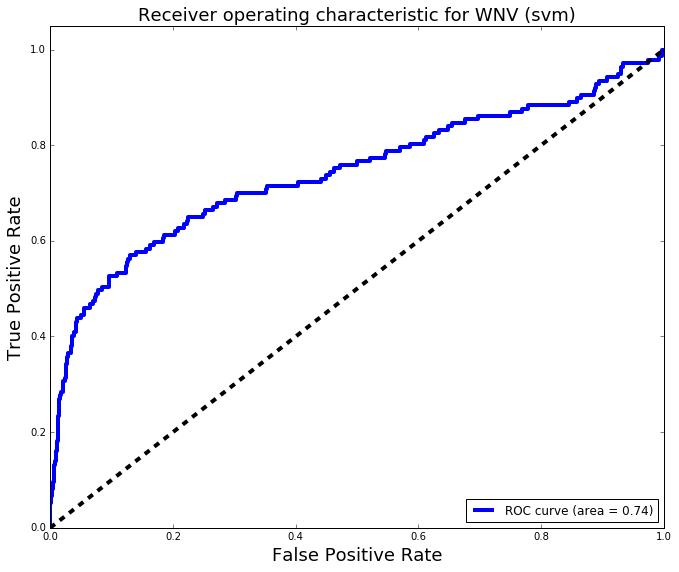

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.wnv, random_state=42)
clf.fit(X_train, y_train)
clf_prob = clf.predict_proba(X_test)[:,1]
clffpr = dict()
clftpr = dict()
clfroc_auc=dict()
clffpr[1], clftpr[1], _ = roc_curve(y_test, clf_prob)
clfroc_auc[1] = auc(clffpr[1], clftpr[1])
plt.figure(figsize=[11,9])
plt.plot(clffpr[1], clftpr[1], label='ROC curve (area = %0.2f)' % clfroc_auc[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV (svm)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Try Neural Network (Great ROC curve. We are going to win!)

In [34]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [59]:
xs = X.astype(float).toarray()
ys = np_utils.to_categorical(y)

In [43]:
ys.shape

(8475, 2)

In [99]:
xs.shape

(8475, 150)

In [93]:
def baseline_model():
    model = Sequential()
    model.add(Dense(150, input_dim=150, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [108]:
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=2, batch_size=50, verbose=0)

In [109]:
nnscore = cross_val_score(estimator, xs, ys, cv=cv).mean()
print nnscore

0.94831874412


In [110]:
nn_pred = cross_val_predict(estimator, xs, ys, cv=cv)

In [111]:
cm_nn = np.array(confusion_matrix(y, nn_pred, labels=[1,0]))
confusion_nn = pd.DataFrame(cm_nn, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion_nn

,pred wnv,pred no wnv
wnv,37,420
no wnv,19,7999


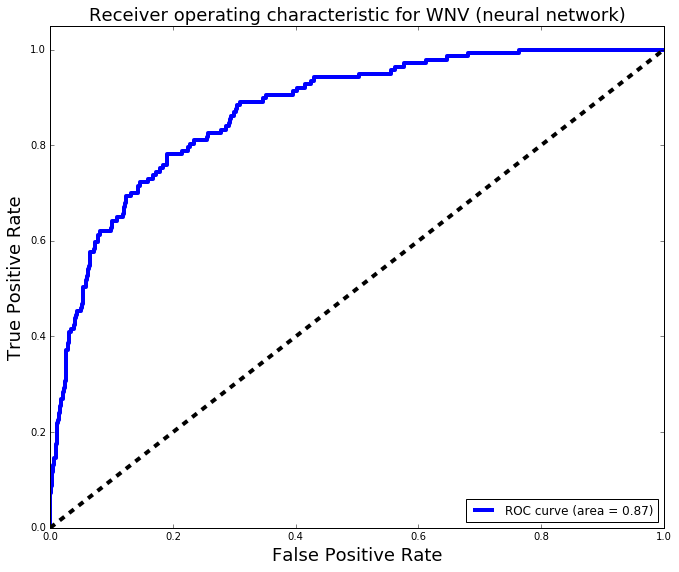

In [112]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3, stratify=df.wnv, random_state=42)
estimator.fit(xs_train, ys_train)
nn_prob = estimator.predict_proba(xs_test)[:,1]
nnfpr = dict()
nntpr = dict()
nnroc_auc=dict()
nnfpr[1], nntpr[1], _ = roc_curve(y_test, nn_prob)
nnroc_auc[1] = auc(nnfpr[1], nntpr[1])
plt.figure(figsize=[11,9])
plt.plot(nnfpr[1], nntpr[1], label='ROC curve (area = %0.2f)' % nnroc_auc[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV (neural network)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [121]:
import seaborn as sns

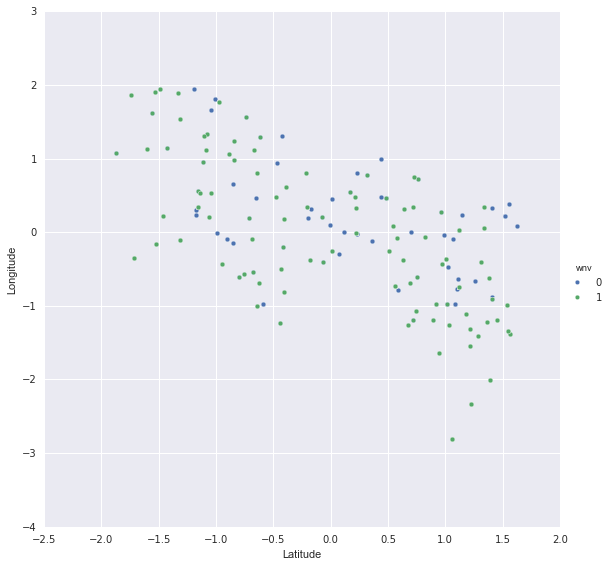

In [127]:
sns.set()
sns.pairplot(df, x_vars='Latitude', y_vars='Longitude', hue='wnv', size=8)